# Updated Modeling - Regression

---

After generating additional temporal features and occupancy rates, I will re-attempt my modeling process. The goal is to improve my model's results with the additional features.

---

# Imports

In [14]:
from joblib import parallel_backend
import json
import numpy as np
import pandas as pd
import seaborn as sns
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers import Winsorizer

from sklearn import metrics
from sklearn import set_config
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer, StandardScaler

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import tensorflow as tf

set_config(transform_output='pandas')

# Load Data

In [15]:
df_data = pd.read_feather('../../data/2.3_data_with_occupancies.feather')
df_data

,IsCanceled,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,...,ADR_7d_avg,ADR_30d_avg,ADR_7d_std,ADR_30d_std,ADR_ewm_3,ADR_ewm_7,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
UUID,,,,,,,,,,,,,,,,,,,,,
b6bcab0c-31d0-44e4-b75f-8829827e31e9,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,41,41,0.115169,0.115169
dea773eb-7d03-4ddf-b0e6-e5767c04eb95,0,2,1.0,0,BB,IRL,Offline TA/TO,TA/TO,0,0,...,82.00,87.43,17.41,16.89,83.17,86.84,41,201,0.115169,0.564607
a8e9c8ff-7d66-4082-a139-bf0f226e4c3d,0,2,0.0,0,BB,IRL,Offline TA/TO,TA/TO,0,0,...,82.53,82.87,16.78,16.76,76.39,82.53,41,201,0.115169,0.564607
2da831f5-1f82-40cf-986a-2cee9ceb4b63,0,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,...,67.26,79.90,10.61,19.67,66.03,75.82,41,201,0.115169,0.564607
8d9af511-c665-4e8c-8cef-a8ffa8bcb6e8,0,3,0.0,0,BB,ESP,Offline TA/TO,TA/TO,0,0,...,69.21,75.73,13.34,14.19,74.19,77.45,41,172,0.115169,0.483146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12af6175-d1a3-4fb3-bb0a-f9798c746ab4,0,2,0.0,0,SC,FRA,Online TA,TA/TO,0,0,...,127.00,114.50,30.31,26.63,136.18,130.86,271,102,0.761236,0.286517
c99d4bd2-691a-4a59-8076-c8455bc407d9,0,2,0.0,0,SC,GBR,Online TA,TA/TO,0,0,...,134.11,130.86,49.18,33.55,152.92,138.32,271,154,0.761236,0.432584
ad7a2ded-b7cc-4116-b52d-c7f284f7ad66,0,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,...,171.53,181.15,39.00,60.50,165.02,170.90,271,154,0.761236,0.432584


In [16]:
df_data.columns

Index(['IsCanceled', 'Adults', 'Children', 'Babies', 'Meal', 'Country',
       'MarketSegment', 'DistributionChannel', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCanceled',
       'ReservedRoomType', 'AssignedRoomType', 'BookingChanges', 'DepositType',
       'Agent', 'Company', 'DaysInWaitingList', 'CustomerType', 'ADR',
       'RequiredCarParkingSpaces', 'TotalOfSpecialRequests',
       'ReservationStatus', 'HotelNumber', 'ArrivalDate', 'DepartureDate',
       'Length of Stay', 'BookingDate', 'DaysSinceBooking',
       'ArrivalDate_DaysBeforeHoliday', 'ArrivalDate_DaysAfterHoliday',
       'DepartureDate_DaysBeforeHoliday', 'DepartureDate_DaysAfterHoliday',
       'BookingDate_DaysBeforeHoliday', 'BookingDate_DaysAfterHoliday',
       'ArrivalWeek', 'ArrivalDay', 'ArrivalDateDayName',
       'ArrivalDateMonthName', 'ADR_lag_1', 'ADR_lag_7', 'ADR_7d_avg',
       'ADR_30d_avg', 'ADR_7d_std', 'ADR_30d_std', 'ADR_ewm_3', 'ADR_ewm_7',
       'occupancy_at_arriv

## Feature Selection

In [17]:
filepath = '../../data/column_groups.json'
with open(filepath, 'r') as file:
    data = json.load(file)

In [18]:
data.keys()

dict_keys(['booking_details', 'post_stay_details', 'reservation_specific', 'temporal_features', 'new_temporal_features'])

In [19]:
data['booking_details']

['UUID',
 'HotelNumber',
 'Adults',
 'Children',
 'Babies',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'DepositType',
 'Agent',
 'Company',
 'CustomerType',
 'ADR']

In [20]:
data['new_temporal_features']

['ADR_30d_avg',
 'ADR_30d_std',
 'ADR_7d_avg',
 'ADR_7d_std',
 'ADR_ewm_3',
 'ADR_ewm_7',
 'ADR_lag_1',
 'ADR_lag_7',
 'ArrivalDateDayName',
 'ArrivalDateMonthName',
 'ArrivalDate_DaysAfterHoliday',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDay',
 'ArrivalWeek',
 'BookingDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'DaysSinceBooking',
 'DepartureDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'Length of Stay']

In [21]:
selected_features = data['booking_details']

selected_features.extend(data['new_temporal_features'])
selected_features.remove('UUID')
selected_features.remove('ADR')
selected_features

['HotelNumber',
 'Adults',
 'Children',
 'Babies',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'DepositType',
 'Agent',
 'Company',
 'CustomerType',
 'ADR_30d_avg',
 'ADR_30d_std',
 'ADR_7d_avg',
 'ADR_7d_std',
 'ADR_ewm_3',
 'ADR_ewm_7',
 'ADR_lag_1',
 'ADR_lag_7',
 'ArrivalDateDayName',
 'ArrivalDateMonthName',
 'ArrivalDate_DaysAfterHoliday',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDay',
 'ArrivalWeek',
 'BookingDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'DaysSinceBooking',
 'DepartureDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'Length of Stay']

# Specify Target Feature

In [22]:
target_feature = 'ADR'

# Train/Test Split

In [23]:
X = df_data.loc[:, selected_features]
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 903)

# Modeling Pipeline - No Hyperparameter Tuning

In [24]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', CountFrequencyEncoder(unseen = 'encode',
                                                           encoding_method = 'frequency',
                                                           missing_values='ignore'))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                         ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
                         ('scaler', MinMaxScaler()),
                         ('powertransformer', PowerTransformer(method='yeo-johnson'))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## ---  Create the TransformedTargetRegressor with Yeo-Johnson transformation --- ##
target_transformer = PowerTransformer(method='yeo-johnson')

base_regressor = RandomForestRegressor(n_jobs = -1)

regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

## --- Build the full pipeline --- ##
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', regressor)])

## --- Fit the model and generate predictions --- ##
with parallel_backend('loky', n_jobs=-1):

      model_pipeline.fit(X_train, y_train)
      y_pred = model_pipeline.predict(X_test)

## --- Evaluate performance metrics --- ##
score_training = model_pipeline.score(X_train, y_train)
score_testing = model_pipeline.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)
mse = metrics.mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)


print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(



Training Score: 0.944
Testing Score: 0.816
Difference: 0.128

The MAE is $12.43
The MedAE is $7.14
The RMSE is $20.57



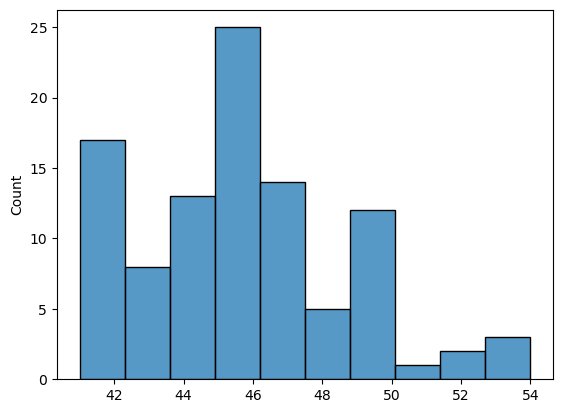

In [12]:
depths = [tree.get_depth() for tree in model_pipeline[-1].regressor_.estimators_]

sns.histplot(depths);

# Modeling Pipeline - With Hyperparameter Tuning

In [33]:
# Select categorical and numerical features
cat_feats = X_train.select_dtypes(include=['object']).columns
num_feats = X_train.select_dtypes(include=['number']).columns

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', CountFrequencyEncoder(unseen='encode',
                                      encoding_method='frequency',
                                      missing_values='ignore'))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
    ('scaler', StandardScaler()),
    ('powertransformer', PowerTransformer(method='yeo-johnson'))
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Create the TransformedTargetRegressor with Yeo-Johnson transformation
target_transformer = PowerTransformer(method='yeo-johnson')

base_regressor = RandomForestRegressor(n_jobs = -1)

regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

# Build the full pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Set up hyperparameter tuning with HalvingGridSearchCV
param_grid = {
    'regressor__regressor__max_depth': [40, 50],
    'regressor__regressor__min_samples_split': [2, 5],
    'regressor__regressor__min_samples_leaf': [1, 2, 4]
}

halving_grid_search = HalvingGridSearchCV(model_pipeline,
                                          param_grid,
                                          scoring='neg_median_absolute_error',
                                          cv=3,
                                          n_jobs = -1,
                                          factor=2,
                                          min_resources="exhaust")

## --- Fit the model and generate predictions --- ##
with parallel_backend('loky', n_jobs=-1):

    # Fit the model and generate predictions
    halving_grid_search.fit(X_train, y_train)

best_model = halving_grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate performance metrics
score_training = best_model.score(X_train, y_train)
score_testing = best_model.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.2f}\n'
      f'Testing Score: {score_testing:,.2f}\n'
      f'Difference: {score_training - score_testing:,.2f}\n')

mean_ae = metrics.mean_absolute_error(y_test, y_pred)
median_ae = metrics.median_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(



Training Score: 0.89
Testing Score: 0.81
Difference: 0.08

The MAE is $12.46
The MedAE is $7.15
The RMSE is $20.79



# New NN Model

In [34]:
# Identify numerical and categorical features
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
#                          ('encoder', CountFrequencyEncoder(unseen = 'encode',
#                                                            encoding_method = 'frequency',
#                                                            missing_values='ignore'))])

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(drop = 'first',
                                                   sparse_output=False,
                                                   handle_unknown='infrequent_if_exist',
                                                   max_categories=15))])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
    ('scaler', MinMaxScaler()),
    ('powertransformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

# Preprocess the features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Perform Yeo-Johnson transformation on the target
target_transformer = PowerTransformer(method='yeo-johnson')
y_train_transformed = target_transformer.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = target_transformer.transform(y_test.values.reshape(-1, 1))

# Convert data to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_transformed = tf.convert_to_tensor(y_train_transformed, dtype=tf.float32)
y_test_transformed = tf.convert_to_tensor(y_test_transformed, dtype=tf.float32) 

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [35]:
def build_model():
        # Build the single-layer neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1)
    ])


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='mean_absolute_error')
    model.summary()
    return model

In [36]:
# Train the model
model = build_model()
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,553 (217.00 KB)

 Trainable params: 55,553 (217.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 28.4293 - val_loss: 18.5815
Epoch 2/100
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 18.3157 - val_loss: 17.5867
Epoch 3/100
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step - loss: 17.2871 - val_loss: 17.2787
Epoch 4/100
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 17.1371 - val_loss: 16.9210
Epoch 5/100
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step - loss: 16.5238 - val_loss: 16.5795
Epoch 6/100
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 16.2182 - val_loss: 16.2169
Epoch 7/100
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 15.8479 - val_loss: 15.7911
Epoch 8/100
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 983us/step - loss: 15.4454 - val_loss: 15.7081
Epoch 9/100
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 15.1495 - val_loss: 15.5762
Epoch 10/100
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 15.0439 - val_loss: 15.2728
Epoch 11/100
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 14.8796 - val_loss:

2799/2799 ━━━━━━━━━━━━━━━━━━━━ 2s 559us/step - loss: 9.4167
Mean Absolute Error on Training Data: 10.16
933/933 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - loss: 13.1759
Mean Absolute Error on Test Data: 13.16
933/933 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step

The MAE is $13.16
The MedAE is $7.78
The RMSE is $20.82



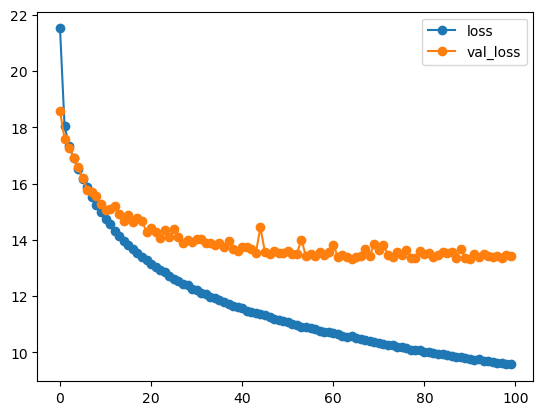

In [37]:

# Evaluate the model
loss = model.evaluate(X_train, y_train, verbose=1)
print(f'Mean Absolute Error on Training Data: {loss:.2f}')

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Mean Absolute Error on Test Data: {loss:.2f}')

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance metrics
mean_ae = metrics.mean_absolute_error(y_test, y_pred)
median_ae = metrics.median_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'\nThe MAE is ${mean_ae:.2f}\n'
      f'The MedAE is ${median_ae:.2f}\n'
      f'The RMSE is ${rmse:.2f}\n')

history_df = pd.DataFrame(history.history)
history_df.plot(marker = 'o');

# Results

---

***Keep It Simple Stupid***

Despite adding additional features, the new model performs worse than the initial model. This may be due to the added complexity of the engineered features and demonstrates the strength of the initial predictors.

***Next Steps***

Now, I want to see how well true time series forecasting models will perform. I will start with a SARIMA model for only the ADR, with a VARMA model as the "above and beyond" step.

---